# Imports

In [65]:
from scipy.stats import shapiro, levene, tukey_hsd
from statsmodels.api import qqplot
import statsmodels.stats as stats
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

plt.style.use("fivethirtyeight")

# Load Data

In [2]:
df = pd.read_csv("../data/PostTypeAnalysisDateset.csv")
df.head()

,post_date,entity_id,followers,is_picture,is_video,video_duration_secs,impressions,likes,shares,replies,engagement_rate
0,1/2/20 17:10,7AD030340F434EECA5B4FC28034E1113,242458.0,False,False,NaN,36023.36585,123,3,42,0.000693
1,1/2/20 17:46,7AD030340F434EECA5B4FC28034E1113,242458.0,False,False,NaN,23402.68323,4,0,0,0.000017
2,10/9/20 16:06,4AAFEFB838974FDCA41932C4D32FD52A,2102820.0,False,False,NaN,204639.92030,24,1,2,0.000013
3,10/9/20 16:08,4AAFEFB838974FDCA41932C4D32FD52A,2102820.0,False,False,NaN,208872.73630,91,1,2,0.000045
4,10/10/20 13:00,4A3372EBDC9C484AA8503A96CD14B858,1023570.0,False,False,NaN,136020.57130,465,9,2,0.000465


# Basic inspection

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15141 entries, 0 to 15140
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   post_date            15141 non-null  object 
 1   entity_id            15141 non-null  object 
 2   followers            15127 non-null  float64
 3   is_picture           15141 non-null  bool   
 4   is_video             15141 non-null  bool   
 5   video_duration_secs  1989 non-null   float64
 6   impressions          15127 non-null  float64
 7   likes                15141 non-null  int64  
 8   shares               15141 non-null  int64  
 9   replies              15141 non-null  int64  
 10  engagement_rate      15141 non-null  float64
dtypes: bool(2), float64(4), int64(3), object(2)
memory usage: 1.1+ MB


In [4]:
df.isnull().sum()

post_date                  0
entity_id                  0
followers                 14
is_picture                 0
is_video                   0
video_duration_secs    13152
impressions               14
likes                      0
shares                     0
replies                    0
engagement_rate            0
dtype: int64

## It seems like 14 posts are not useful because they have NaN impressions and NaN followers. They do have an engagement rate but for consistency, I'll drop them

In [7]:
df = df.dropna(subset="followers")
df.isnull().sum() # sanity check that NaN followers is related to NaN impressions

post_date                  0
entity_id                  0
followers                  0
is_picture                 0
is_video                   0
video_duration_secs    13140
impressions                0
likes                      0
shares                     0
replies                    0
engagement_rate            0
dtype: int64

# EDA for post type (ae. pic, vid, neither)

In [8]:
print(f"Number of posts that contain both pics and videos: {df[df.is_picture & df.is_video].shape[0]}")
print(f"Number of posts that only contain a picture: {df[df.is_picture & ~df.is_video].shape[0]}")
print(f"Number of posts that only contain a video: {df[df.is_video & ~df.is_picture].shape[0]}")
print(f"Number of posts that contain neither a picture nor a video: {df[~df.is_picture & ~df.is_video].shape[0]}")

Number of posts that contain both pics and videos: 0
Number of posts that only contain a picture: 4684
Number of posts that only contain a video: 1987
Number of posts that contain neither a picture nor a video: 8456


## I have 3 groups to compare

In [9]:
only_pic = df[df.is_picture & ~df.is_video].copy()
only_vid = df[df.is_video & ~df.is_picture].copy()
neither = df[~df.is_picture & ~df.is_video].copy()

# Impressions by group

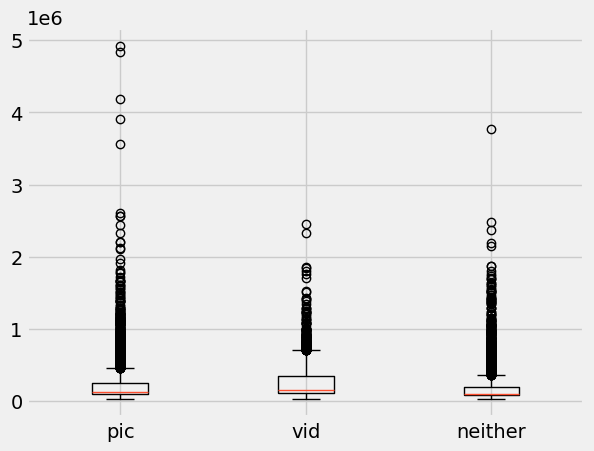

In [23]:
fig, ax = plt.subplots()
ax.boxplot([only_pic["impressions"], only_vid["impressions"], neither["impressions"]], labels=["pic", "vid", "neither"])
plt.show()

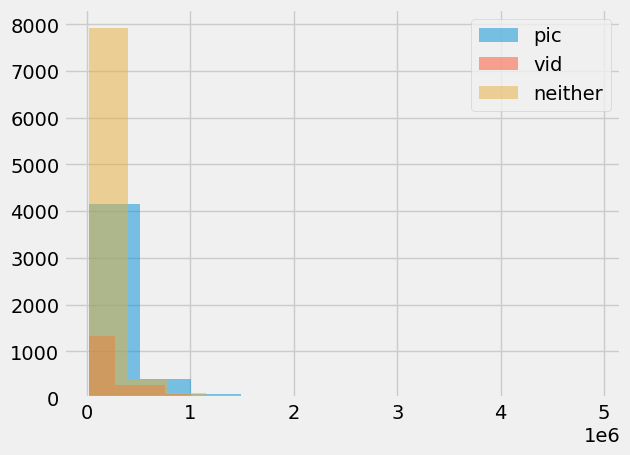

In [25]:
plt.hist(only_pic["impressions"], label="pic", alpha=.5)
plt.hist(only_vid["impressions"], label="vid", alpha=.5)
plt.hist(neither["impressions"], label="neither", alpha=.5)
plt.legend()
plt.show()

## It looks like maybe, pic and vid are skew right more than neither

# Test for difference in impression means between groups

**H<sub>0</sub>**: The average impressions amoung posts that contain a picture, video, or neither are the same

**H<sub>1</sub>**: The average impressions amoung posts that contain a picture, video, or neither are not the same

I want to run an anova but need to check that assumptions are not violated

## Test for normality

Clearly the distributions aren't normal and ANOVA is robust against normality but might as well check

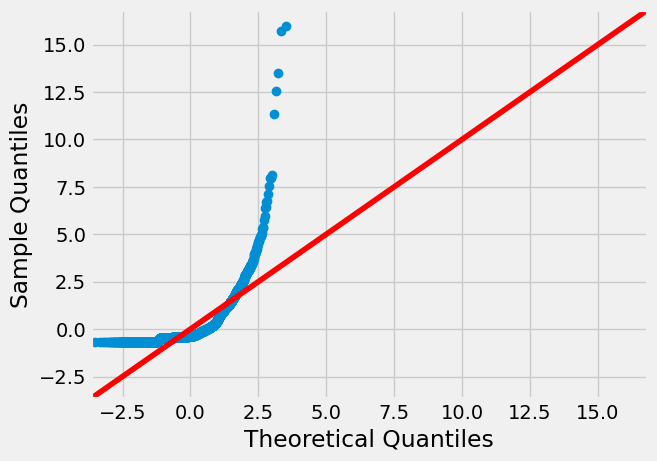

In [31]:
qqplot(only_pic["impressions"], line="45", fit=True)

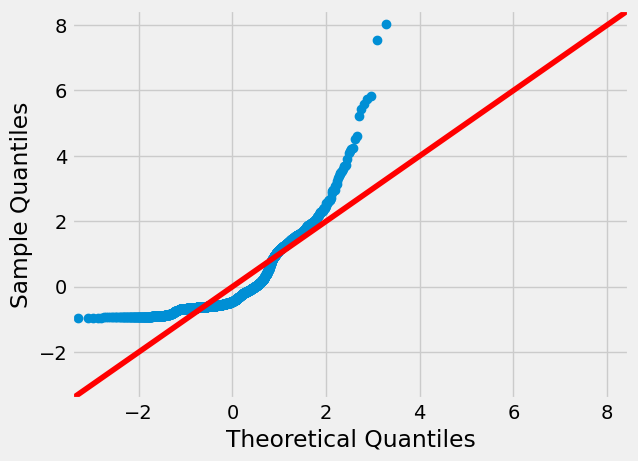

In [32]:
qqplot(only_vid["impressions"], line="45", fit=True)

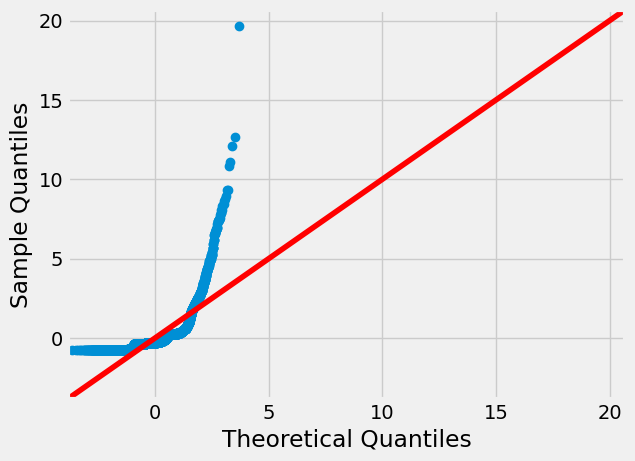

In [33]:
qqplot(neither["impressions"], line="45", fit=True)

#### From the qqplot, we can see that they aren't normally distruibuted but to cover all bases, running the shapiro-wilk test for normality

In [36]:
shapiro(only_pic["impressions"]).pvalue, shapiro(only_vid["impressions"]).pvalue, shapiro(neither["impressions"]).pvalue

C:\Users\allan\.virtualenvs\eg_assessment-nlFCfaXA\lib\site-packages\scipy\stats\_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


(0.0, 0.0, 0.0)

#### Got a warning but visually from the histogram and the qqplot we can see that the impressions are not distributed normally, and sketchy pvalue also agrees. ANOVA is robust against normality so lets check that the variances are approximately equal

## Test for equal variance

In [54]:
variances = np.array([only_pic["impressions"].var(), only_vid["impressions"].var(), neither["impressions"].var()])
variances

array([8.58810461e+10, 7.39113664e+10, 3.36963504e+10])

#### Looks like picture and video are similar but neither is not. Running Levene since data is not normally ditributed

In [50]:
levene(only_pic["impressions"], only_vid["impressions"], neither["impressions"], center="mean").pvalue

1.1210304992296123e-156

#### Tests confirms suspicion that variances are un-equal so can't use ANOVA using Whelch's ANOVA instead

In [55]:
means = np.array([only_pic["impressions"].mean(), only_vid["impressions"].mean(), neither["impressions"].mean()])
num_obs = np.array([only_pic.shape[0], only_vid.shape[0], neither.shape[0]])

In [62]:
stats.oneway.anova_generic(means, variances, num_obs).pvalue < .05

True

#### There is a difference in average impressions between groups

## Post Hoc tests on average impressions between groups

In [83]:
pairwise_comp = tukey_hsd(only_pic["impressions"], only_vid["impressions"], neither["impressions"])
conf = pairwise_comp.confidence_interval(.95)
print(pairwise_comp)

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1) -49451.947     0.000-64186.919-34716.975
 (0 - 2)  72347.110     0.000 62322.489 82371.731
 (1 - 0)  49451.947     0.000 34716.975 64186.919
 (1 - 2) 121799.057     0.000108077.846135520.268
 (2 - 0) -72347.110     0.000-82371.731-62322.489
 (2 - 1) -121799.057     0.000-135520.268-108077.846



#### All means are statistically significantly different from eachother

## Visualze the differences

In [86]:
conf_mean = pairwise_comp.statistic.flatten()
conf_mean = [conf_mean[2], conf_mean[3], conf_mean[5]]
conf_mean

[72347.10994594736, 49451.94715038655, 121799.05709633391]

In [88]:
low = conf.low.flatten()
low = np.array([low[2], low[3], low[5]])
high = conf.high.flatten()
high = np.array([high[2], high[3], high[5]])
conf_error = (high - low) / 2
conf_error

array([10024.62127884, 14734.97202493, 13721.21092319])

In [91]:
conf_names = ["picture - neither", "video - pic", "video - neither"]

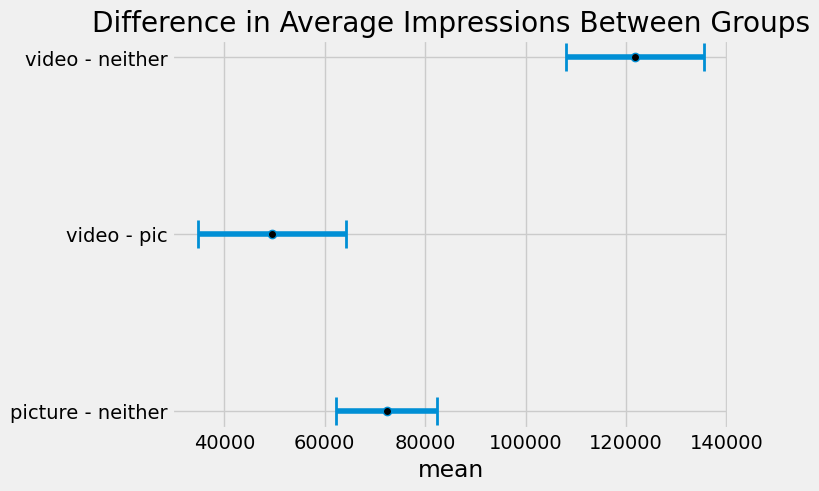

In [109]:
plt.errorbar(x=conf_mean, y=range(1,4), xerr=conf_error, ls="none", marker="o", capsize=10, capthick=2, markerfacecolor="black")
plt.xlabel("mean")
plt.title("Difference in Average Impressions Between Groups")
plt.yticks(ticks=range(1, 4), labels=conf_names)
plt.show()

## Findings

The Whelch's ANOVA we ran showed (to a 5% significance level) that the average impressions between the groups are different. Post-hoc analysis using Tukey's HSD (at a 5% significance level) showed that none of the means between groups are the same. More specifically, on average, posts with videos get more impressions than posts with neither videos nor pictures, posts with pictures get more impressions than posts with neither videos nor pictures, and posts with videos out-preform posts with pictures. On average, posts with videos get between 34k - 64k more impressions than posts with pictures.

Our findings indicate that posts with videos get the highest impressions on average and thus I suggest we include a video in our posts.

In [108]:
round(conf_mean[1] - conf_error[1]), round(conf_mean[1] + conf_error[1])

(34717, 64187)

# Engagement Rate by Group

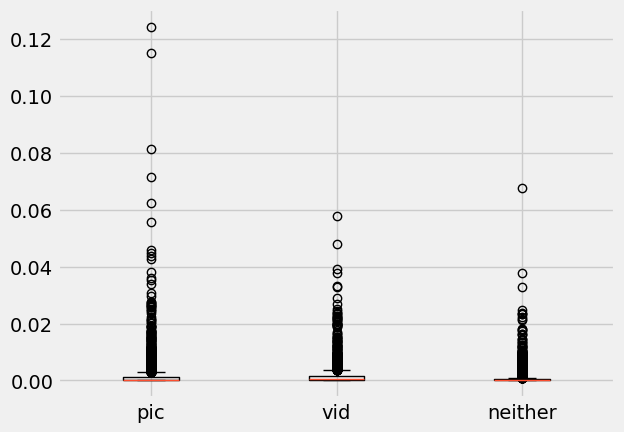

In [110]:
fig, ax = plt.subplots()
ax.boxplot([only_pic["engagement_rate"], only_vid["engagement_rate"], neither["engagement_rate"]], labels=["pic", "vid", "neither"])
plt.show()

### Looks like they are quite similar but it's hard to say since the graph is so squished

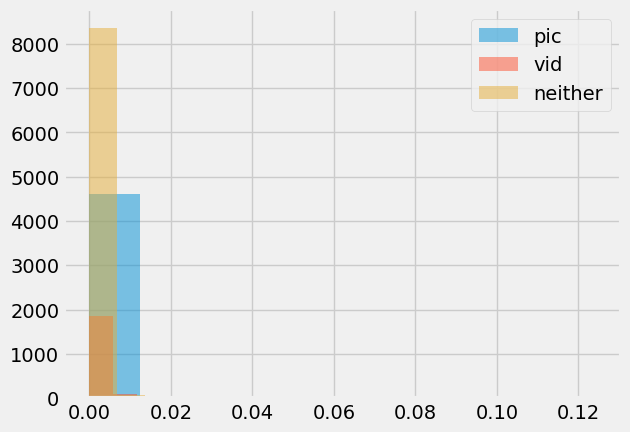

In [111]:
plt.hist(only_pic["engagement_rate"], label="pic", alpha=.5)
plt.hist(only_vid["engagement_rate"], label="vid", alpha=.5)
plt.hist(neither["engagement_rate"], label="neither", alpha=.5)
plt.legend()
plt.show()

### Hard to gleam any insight from this figure

In [113]:
only_pic["engagement_rate"].mean(), only_vid["engagement_rate"].mean(), neither["engagement_rate"].mean()

(0.0014357204592228864, 0.0018277465732259687, 0.0005513585132450331)

### Engagement rate for pictures and videos are roughly the same but text posts are quite worse

# Test for difference in average engagment rate by group

**H<sub>0</sub>**: The average engagement rate amoung posts that contain a picture, video, or neither are the same

**H<sub>1</sub>**: The average engagement rate amoung posts that contain a picture, video, or neither are not the same

## Test Assumptions for ANOVA

### Normality

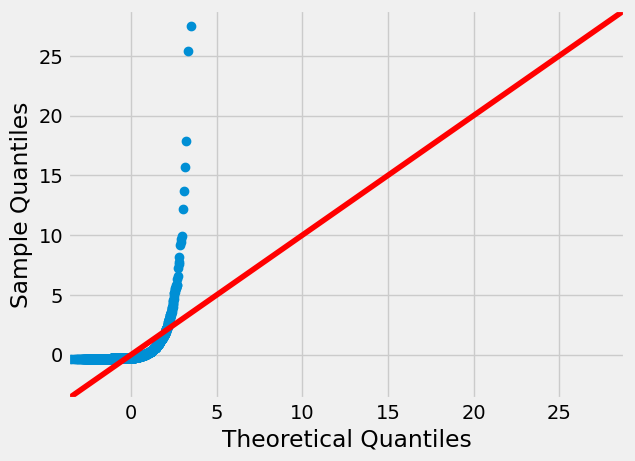

In [114]:
qqplot(only_pic["engagement_rate"], line="45", fit=True)

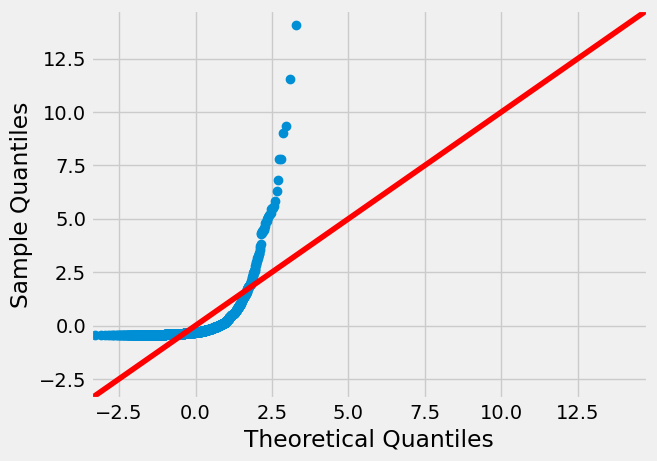

In [116]:
qqplot(only_vid["engagement_rate"], line="45", fit=True)

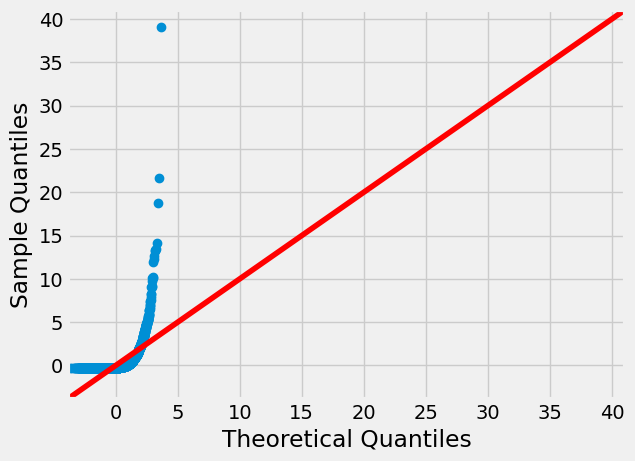

In [117]:
qqplot(neither["engagement_rate"], line="45", fit=True)

In [118]:
shapiro(only_pic["engagement_rate"]).pvalue, shapiro(only_vid["engagement_rate"]).pvalue, shapiro(neither["engagement_rate"]).pvalue

C:\Users\allan\.virtualenvs\eg_assessment-nlFCfaXA\lib\site-packages\scipy\stats\_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


(0.0, 0.0, 0.0)

#### Assumption of normality is violated but ANOVA is robust so check for ~equal variances

### Approximately equal variances

In [120]:
levene(only_pic["engagement_rate"], only_vid["engagement_rate"], neither["engagement_rate"], center="mean")

LeveneResult(statistic=292.8021522270468, pvalue=1.7288508889936384e-125)

#### Variance assumption is violated using Whelch's ANOVA instead

In [122]:
variances = np.array([only_pic["engagement_rate"].var(), only_vid["engagement_rate"].var(), neither["engagement_rate"].var()])
means = np.array([only_pic["engagement_rate"].mean(), only_vid["engagement_rate"].mean(), neither["engagement_rate"].mean()])
num_obs = np.array([only_pic.shape[0], only_vid.shape[0], neither.shape[0]])

In [123]:
stats.oneway.anova_generic(means, variances, num_obs).pvalue < .05

True

#### The average impression rate does differ between groups

## Post-hoc Analysis between groups

In [124]:
pairwise_comp = tukey_hsd(only_pic["engagement_rate"], only_vid["engagement_rate"], neither["engagement_rate"])
conf = pairwise_comp.confidence_interval(.95)
print(pairwise_comp)

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)     -0.000     0.000    -0.001    -0.000
 (0 - 2)      0.001     0.000     0.001     0.001
 (1 - 0)      0.000     0.000     0.000     0.001
 (1 - 2)      0.001     0.000     0.001     0.001
 (2 - 0)     -0.001     0.000    -0.001    -0.001
 (2 - 1)     -0.001     0.000    -0.001    -0.001



## Visualize differences

In [125]:
conf_mean = pairwise_comp.statistic.flatten()
conf_mean = [conf_mean[2], conf_mean[3], conf_mean[5]]
low = conf.low.flatten()
low = np.array([low[2], low[3], low[5]])
high = conf.high.flatten()
high = np.array([high[2], high[3], high[5]])
conf_error = (high - low) / 2
conf_names = ["picture - text", "video - pic", "video - text"]

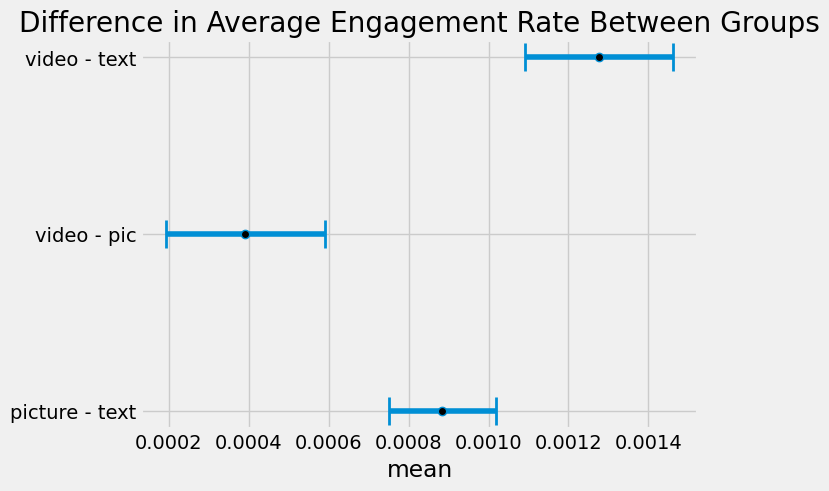

In [127]:
plt.errorbar(x=conf_mean, y=range(1,4), xerr=conf_error, ls="none", marker="o", capsize=10, capthick=2, markerfacecolor="black")
plt.xlabel("mean")
plt.title("Difference in Average Engagement Rate Between Groups")
plt.yticks(ticks=range(1, 4), labels=conf_names)
plt.show()

# Findings

The results are pretty identical to what we saw for impressions. Video does better than text, picture does better than text, and video does better than picture.

# Since videos out-preform other forms of posts for our KPIs. Does video length affect those KPIs?